In [ ]:
pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset

100% 149M/149M [00:05<00:00, 27.7MB/s]
100% 149M/149M [00:05<00:00, 31.1MB/s]


In [ ]:
! unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [ ]:
import os
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adamax

print ('modules loaded')

modules loaded


In [ ]:
tr_df_path="/content/Training"
labels=[]
filepaths=[]

folds=os.listdir(tr_df_path)
for fold in folds:
    foldpath=os.path.join(tr_df_path,fold)
    foldlist=os.listdir(foldpath)
    for file in foldlist:
        filepath=os.path.join(foldpath,file)

        labels.append(fold)
        filepaths.append(filepath)


l=pd.Series(labels,name="labels")
f=pd.Series(filepaths,name="filepaths")

tr_df=pd.concat([f,l],axis=1)

tr_df

,filepaths,labels
0,/content/Training/meningioma/Tr-me_1049.jpg,meningioma
1,/content/Training/meningioma/Tr-me_0154.jpg,meningioma
2,/content/Training/meningioma/Tr-me_0053.jpg,meningioma
3,/content/Training/meningioma/Tr-me_1167.jpg,meningioma
4,/content/Training/meningioma/Tr-me_0781.jpg,meningioma
...,...,...
5707,/content/Training/glioma/Tr-gl_0957.jpg,glioma
5708,/content/Training/glioma/Tr-gl_0381.jpg,glioma
5709,/content/Training/glioma/Tr-gl_0597.jpg,glioma
5710,/content/Training/glioma/Tr-gl_0560.jpg,glioma


In [ ]:
tst_df_path="/content/Testing"
labels=[]
filepaths=[]

folds=os.listdir(tst_df_path)
for fold in folds:
    foldpath=os.path.join(tst_df_path,fold)
    foldlist=os.listdir(foldpath)
    for file in foldlist:
        filepath=os.path.join(foldpath,file)

        labels.append(fold)
        filepaths.append(filepath)

l=pd.Series(labels,name="labels")
f=pd.Series(filepaths,name="filepaths")

ts_df=pd.concat([f,l],axis=1)

ts_df

,filepaths,labels
0,/content/Testing/meningioma/Te-me_0088.jpg,meningioma
1,/content/Testing/meningioma/Te-me_0105.jpg,meningioma
2,/content/Testing/meningioma/Te-me_0299.jpg,meningioma
3,/content/Testing/meningioma/Te-meTr_0000.jpg,meningioma
4,/content/Testing/meningioma/Te-me_0047.jpg,meningioma
...,...,...
1306,/content/Testing/glioma/Te-gl_0268.jpg,glioma
1307,/content/Testing/glioma/Te-gl_0240.jpg,glioma
1308,/content/Testing/glioma/Te-gl_0123.jpg,glioma
1309,/content/Testing/glioma/Te-gl_0207.jpg,glioma


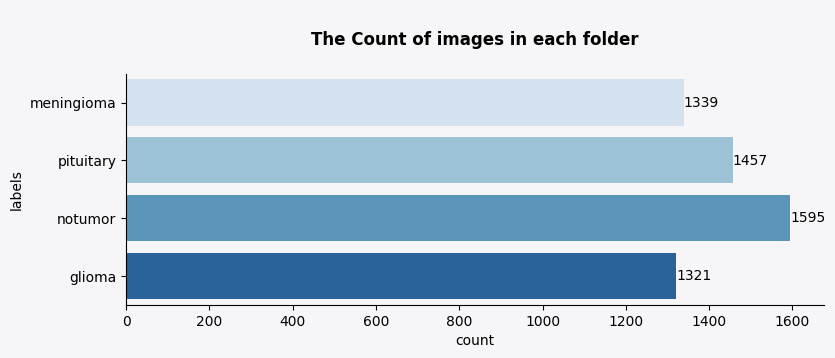

In [ ]:
fig,ax=plt.subplots(figsize=(9,3))
fig.patch.set_facecolor("#f6f5f7")
ax.set_facecolor("#f6f5f7")
for i in ["top","right"]:
    ax.spines[i].set_visible(False)

x = sns.countplot(data=tr_df, y=tr_df["labels"],palette='Blues')
for container in x.containers:
    x.bar_label(container)
plt.title("\nThe Count of images in each folder for training dataset\n",weight="bold");

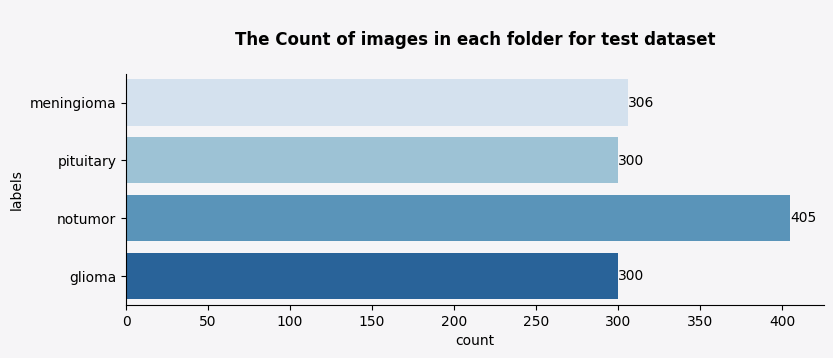

In [ ]:
fig,ax=plt.subplots(figsize=(9,3))
fig.patch.set_facecolor("#f6f5f7")
ax.set_facecolor("#f6f5f7")
for i in ["right","top"]:
    ax.spines[i].set_visible(False)

i=sns.countplot(data=ts_df,y=ts_df["labels"],palette='Blues')
for container in i.containers:
    i.bar_label(container)

plt.title("\nThe Count of images in each folder for test dataset\n",weight="bold");

In [ ]:
print(f'Shape for test dataset {ts_df.shape}\n')
print(f'Shape for training dataset {tr_df.shape}')

Shape for test dataset (1311, 2)

Shape for training dataset (5712, 2)


In [24]:
print('Split dataframe into train, valid, and test\n')
valid_df,tst_df=train_test_split(ts_df,test_size=0.5,random_state=50,stratify=ts_df["labels"])
print(f"ts_df shape: {ts_df.shape}")
print("---"*10)
print(f"valid data shape: {valid_df.shape}")
print(f"test data shape: {tst_df.shape}")
valid_df

Split dataframe into train, valid, and test

ts_df shape: (1311, 2)
------------------------------
valid data shape: (655, 2)
test data shape: (656, 2)


,filepaths,labels
624,/content/Testing/notumor/Te-no_0062.jpg,notumor
570,/content/Testing/pituitary/Te-pi_0118.jpg,pituitary
83,/content/Testing/meningioma/Te-me_0127.jpg,meningioma
1285,/content/Testing/glioma/Te-gl_0273.jpg,glioma
808,/content/Testing/notumor/Te-noTr_0006.jpg,notumor
...,...,...
303,/content/Testing/meningioma/Te-me_0161.jpg,meningioma
438,/content/Testing/pituitary/Te-pi_0262.jpg,pituitary
685,/content/Testing/notumor/Te-no_0095.jpg,notumor
999,/content/Testing/notumor/Te-no_0178.jpg,notumor


Create image data generator

In [25]:
img_size=(224,224)

tr=ImageDataGenerator()
ts=ImageDataGenerator()

train_gen=tr.flow_from_dataframe(tr_df,x_col="filepaths",y_col="labels",
                                 target_size=img_size,
                                 batch_size=16,shuffle=True,
                                 class_mode='categorical',color_mode="rgb")


valid_gen=ts.flow_from_dataframe(ts_df,x_col='filepaths',y_col='labels',
                                target_size=img_size,
                                 class_mode="categorical",color_mode="rgb",
                                 shuffle=True,batch_size=16,)


test_gen=ts.flow_from_dataframe(ts_df, x_col='filepaths', y_col='labels',
                                 target_size=img_size,
                                 batch_size=16, shuffle=False,
                                 color_mode="rgb", class_mode="categorical")

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


Show sample from train data¶


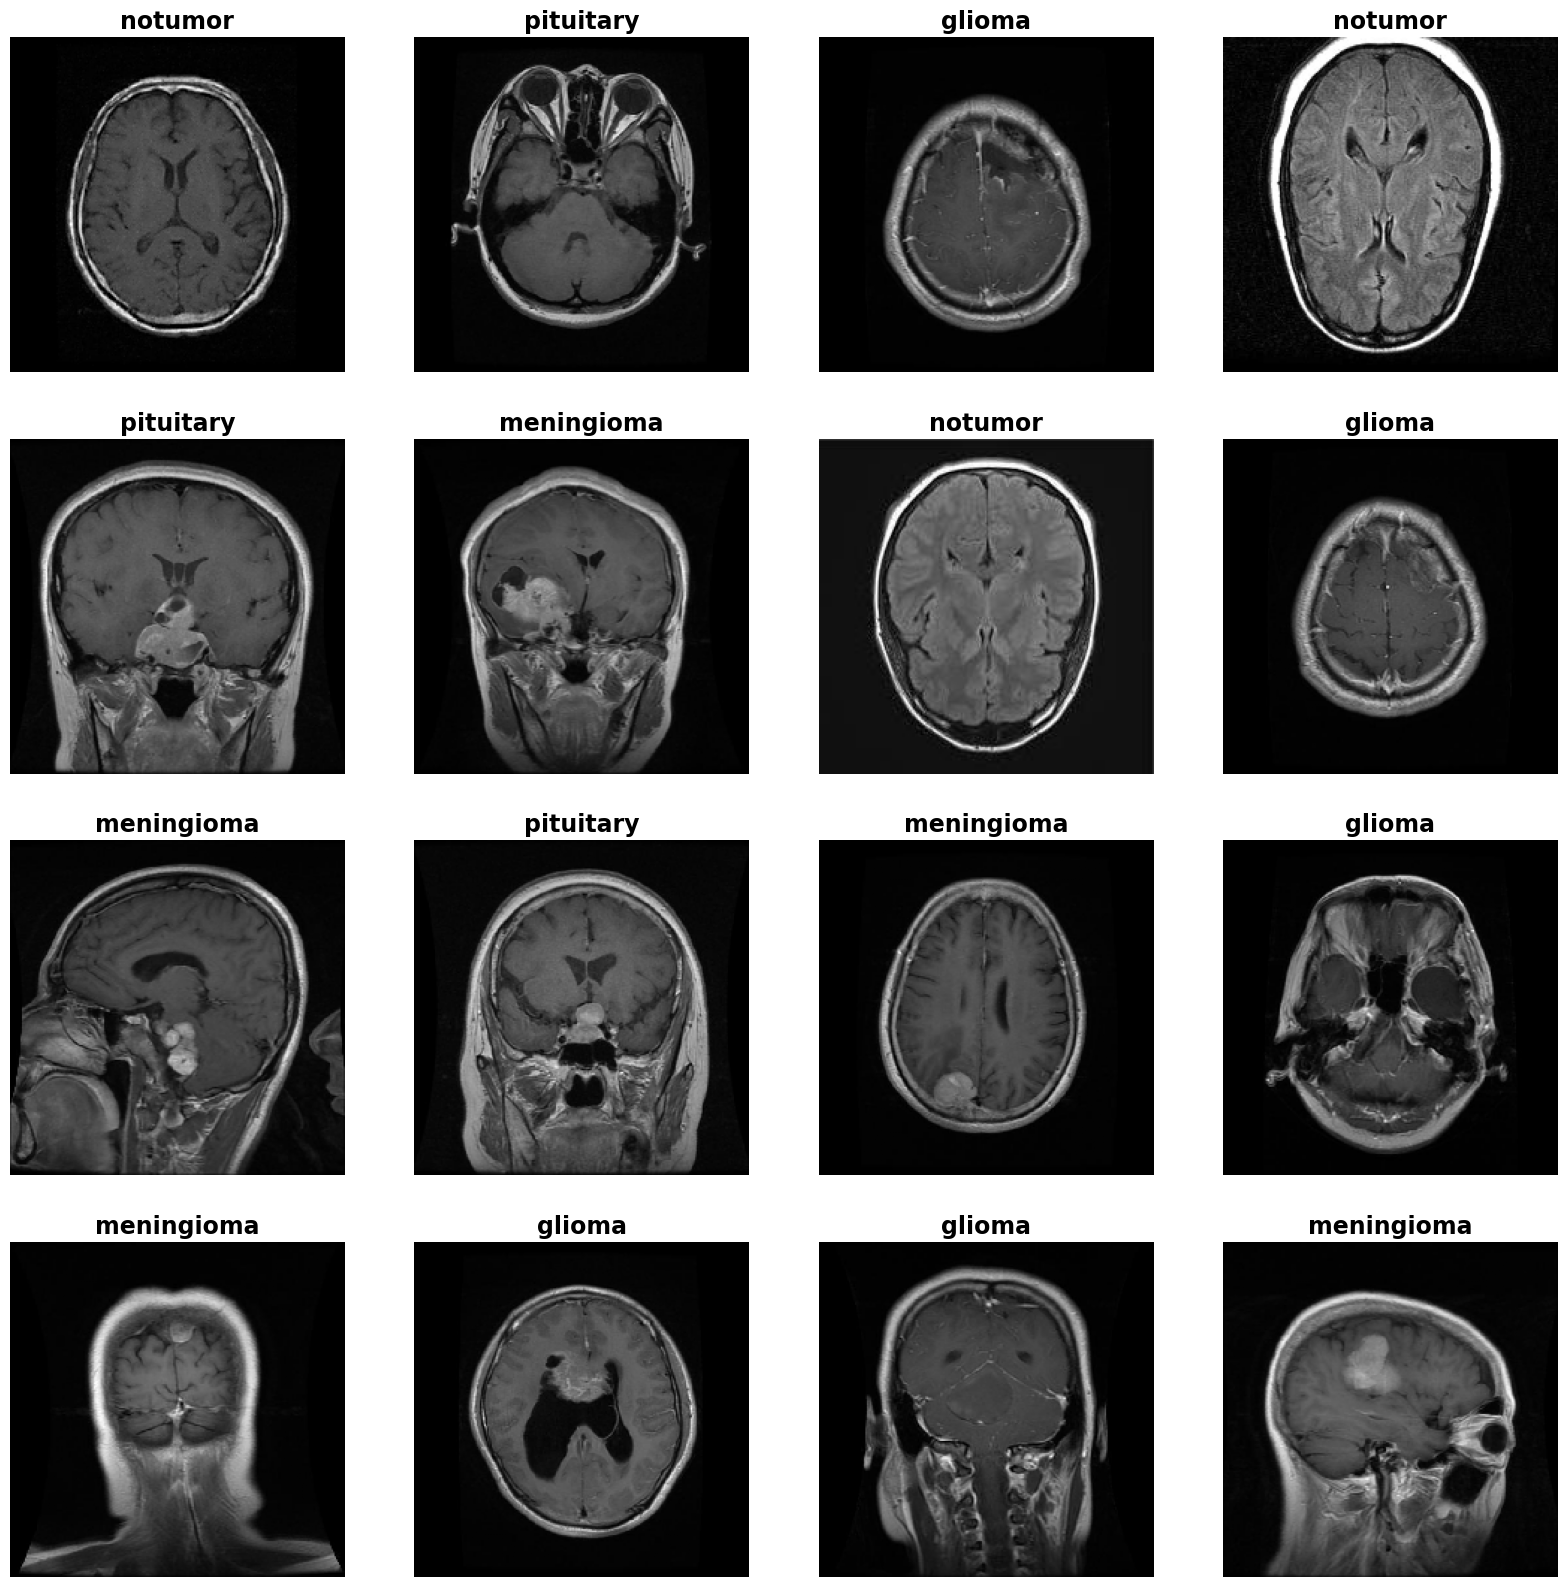

In [26]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'black' , fontsize= 17,weight="bold")
    plt.axis('off')
plt.show()

Building Deep Learning Model

In [27]:
img_shape=(224,224,3)
base_Model = tf.keras.applications.Xception(include_top= False,weights= "imagenet",
                                            input_shape= img_shape, pooling= 'max')

Model = Sequential([
    base_Model,
    Dropout(rate= 0.5),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

Model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

Model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 21124268 (80.58 MB)
Trainable params: 21069740 (80.37 MB)
Non-trainable params: 54528 (213.00 KB)
___________

## Training

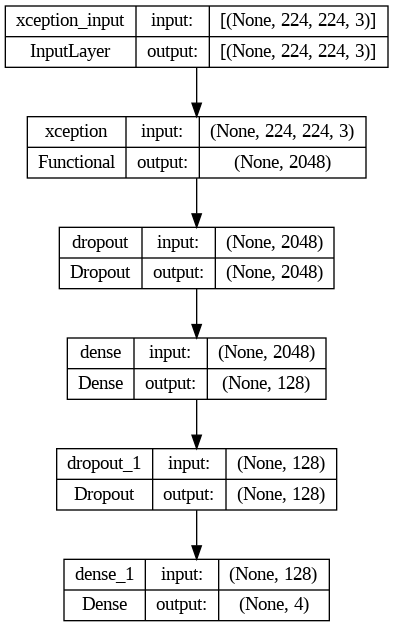

In [28]:
tf.keras.utils.plot_model(Model,show_shapes=True)

In [ ]:
historyy=Model.fit(train_gen,epochs=10,
                  validation_data=valid_gen,
                  shuffle=False)

Epoch 1/10
357/357 [==============================] - 5767s 16s/step - loss: 0.2918 - accuracy: 0.9041 - val_loss: 0.0815 - val_accuracy: 0.9664
Epoch 2/10
114/357 [========>.....................] - ETA: 58:45 - loss: 0.0902 - accuracy: 0.9726

##Visualize model performance¶


In [ ]:
model_json = Model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
Model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
historyy.history.keys()

In [ ]:
plt.figure(figsize=(20, 8))
tr_loss=historyy.history["loss"]
val_loss=historyy.history["val_loss"]
index_loss=np.argmin(val_loss)
loss_lowest=val_loss[index_loss]
l_label=f"best epoch {index_loss+1}"

tr_accuracy=historyy.history["accuracy"]
val_accuracy=historyy.history["val_accuracy"]
index_acc=np.argmax(val_accuracy)
acc_highest=tr_accuracy[index_acc]
c_label=f"best epoch {index_acc+1}"

epochs=[i+1 for i in range (len(tr_accuracy))]


plt.figure(figsize=(20,10))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(epochs,tr_loss,"r",label="train loss")
plt.plot(epochs,val_loss,"g",label="valid loss")
plt.scatter(index_loss+1,loss_lowest,c="b",s=150,label=l_label)
plt.title('Training and Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs,tr_accuracy,"r",label="train accuracy")
plt.plot(epochs,val_accuracy,"g",label="valid accuracy")
plt.scatter(index_acc+1,acc_highest,c="b",s=150,label=c_label)
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()


plt.suptitle('Model Training Metrics Over Epochs', fontsize=20);

##Model Evaluation

In [ ]:
train_score=Model.evaluate(train_gen)
valid_score=Model.evaluate(valid_gen)
test_score=Model.evaluate(test_gen)

print(f"Train Loss : {train_score[0]:.3f}")
print(f"Train Accuracy : {train_score[1]*100:.2f}%")
print("-"*20)
print(f"Validation Loss : {valid_score[0]:.3f}")
print(f"Validation Accuracy : {valid_score[1]*100:.2f}%")
print("-"*20)
print(f"Test Loss: {test_score[0]:.3f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

##Predictive Analysis

In [ ]:
preds=Model.predict(test_gen)
y_pred=np.argmax(preds,axis=1)

###Confusion Matrics and Classification Report

In [ ]:
plt.figure(figsize=(10,5))
plt.style.use('default')
cm=confusion_matrix(test_gen.classes,y_pred)
labels = list(test_gen.class_indices.keys())
sns.heatmap(cm,annot=True,fmt="d",xticklabels=labels,yticklabels=labels,cmap="Blues", linewidths=.5)
plt.xlabel('\nPredicted Label',fontsize=13)
plt.ylabel('Actual Label\n',fontsize=13);

In [ ]:
cr=classification_report(test_gen.classes,y_pred)
print(cr)